# 2022 Kaggle Data Science & Machine Learning Survey

* Every response to every question from 2022, with occasional use of data from 2017, 2018, 2019, 2020, and 2021.
* Consider filtering the data to only include the respondents that you are most interested in (e.g. job title, industry, location, etc)
* Click on the "Copy & Edit" button if you want to explore the data on your own!
* Can you identify any insights about any of the subgroups within the Kaggle community?

# *Step 1: Import Python libraries*

In [1]:
import os
import glob
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 5000)

# *Step 2: Define helper functions*

In [2]:
def bar_chart_multiple_choice(response_counts,title,y_axis_title,orientation='h',num_choices=15): 
    response_counts_series = pd.Series(response_counts)
    response_counts_series.index.name = ''
    pd.DataFrame(response_counts_series).to_csv('/kaggle/working/individual_charts/data/'+title+'.csv',index=True)
    fig = px.bar(response_counts_series,
             labels={"": '',"value": y_axis_title},
             text=response_counts_series.values,
             orientation=orientation,)
    fig.update_layout(showlegend=False,
                      title={'text': title+' in 2022',
                             'y':0.95,
                             'x':0.5,},
                      xaxis_range=[0,max(response_counts_series[0:num_choices]*1.2)])
    fig.write_html('/kaggle/working/individual_charts/charts/'+title+'.html')
    fig.show()
    
    
def bar_chart_multiple_choice_multiple_selection(df,title,orientation='v'):  
    df_new = df.copy()
    counts = df_new[df_new.columns[:]].count().sort_values(ascending=True)
    percentages = counts*100/len(df_new)
    percentages.index.name = ''
    percentages.to_csv('/kaggle/working/individual_charts/data/'+title+'.csv',index=True)
    if orientation is 'v':
        fig = px.bar(percentages,text=np.round(percentages.values,1),orientation=orientation)
        fig.update_layout(
            title=title+' in 2022',
            yaxis_title='% of respondents',
            showlegend=False)
        fig.write_html('/kaggle/working/individual_charts/charts/'+title+'.html')
        fig.show()
    else:
        fig = px.bar(percentages,text=np.round(percentages.values,1),orientation=orientation)
        fig.update_layout(
            title=title+' in 2022',
            xaxis_title='% of respondents',
            showlegend=False)
        fig.write_html('/kaggle/working/individual_charts/charts/'+title+'.html')
        fig.show()    

def bar_chart_multiple_years(df,x_column,y_column,title,y_axis_title):
    df.to_csv('/kaggle/working/individual_charts/data/'+title+'.csv',index=True)
    fig = px.histogram(df, x= x_column, y = y_column,barmode='group',color='year',orientation='v',
    template='ggplot2',
    color_discrete_map={
        '2017': px.colors.sequential.Blues[2],
        '2018': px.colors.sequential.Blues[3],
        '2019': px.colors.sequential.Blues[4],
        '2020': px.colors.sequential.Blues[5],
        '2021': px.colors.sequential.Blues[7],
        '2022': px.colors.sequential.Blues[8]})
    fig.update_layout(title=title_for_chart,yaxis=dict(title=title_for_y_axis))
    fig.update_layout(legend=dict(yanchor="auto",y=0))
    fig.write_html('/kaggle/working/individual_charts/charts/'+title+'.html')
    fig.show()


def create_choropleth_map(df, column, title, max_value):
    df.to_csv('/kaggle/working/individual_charts/data/'+title+'.csv',index=True)
    fig = px.choropleth(df, 
                    locations = 'country',  
                    color = column,
                    locationmode = 'country names', 
                    color_continuous_scale = 'viridis',
                    title = title,
                    range_color = [0, max_value])
    fig.update(layout=dict(title=dict(x=0.5)))
    fig.write_html('/kaggle/working/individual_charts/charts/'+title+'.html')
    fig.show()

In [3]:
def grab_subset_of_data(original_df, question_of_interest):
    # adapted from https://www.kaggle.com/siddhantsadangi/your-country-vs-the-world-24-factors-wip
    new_df = original_df.copy()
    subset_of_columns = [col for col in new_df.columns if question_of_interest in col]
    mapper = [col.split('-')[-1].lstrip() for col in subset_of_columns]
    mapping_dict = dict(zip(subset_of_columns,mapper))
    new_df = new_df[subset_of_columns].rename(columns=mapping_dict)
    new_df.dropna(how='all', subset=mapper, inplace=True)
    return new_df

def create_dataframe_of_counts(dataframe,column,rename_index,rename_column,return_percentages=False): 
    df = dataframe[column].value_counts().reset_index() 
    if return_percentages==True:
        df[column] = (df[column]*100)/(df[column].sum())
    df = pd.DataFrame(df) 
    df = df.rename({'index':rename_index, column:rename_column}, axis='columns')
    return df

def count_then_return_percent(dataframe,x_axis_title): 
    counts = dataframe[x_axis_title].value_counts(dropna=False)
    percentages = round(counts*100/(dataframe[x_axis_title].count()),1)
    return percentages

def add_year_column_to_dataframes(df_2022,df_2021,df_2020,df_2019,df_2018,df_2017=None):
    if df_2017 is not None:
        df_2022['year'] = '2022'
        df_2021['year'] = '2021'
        df_2020['year'] = '2020'
        df_2019['year'] = '2019'
        df_2018['year'] = '2018'
        df_2017['year'] = '2017'
        return df_2017,df_2018,df_2019,df_2020,df_2021,df_2022
    else:
        df_2022['year'] = '2022'
        df_2021['year'] = '2021'
        df_2020['year'] = '2020'
        df_2019['year'] = '2019'
        df_2018['year'] = '2018'
        return df_2018,df_2019,df_2020,df_2021,df_2022

def convert_df_of_counts_to_percentages(df,df_counts): 
    df_combined_percentages = df_counts.copy().astype(int)
    df_combined_percentages[0:1] = df_combined_percentages[0:1]*100/df['year'].eq('2018').sum()
    df_combined_percentages[1:2] = df_combined_percentages[1:2]*100/df['year'].eq('2019').sum()
    df_combined_percentages[2:3] = df_combined_percentages[2:3]*100/df['year'].eq('2020').sum()
    df_combined_percentages[3:4] = df_combined_percentages[3:4]*100/df['year'].eq('2021').sum()
    df_combined_percentages[4:5] = df_combined_percentages[4:5]*100/df['year'].eq('2022').sum()
    df_combined_percentages['year'] = ['2018','2019','2020','2021','2022']
    return df_combined_percentages

In [4]:
def combine_subset_of_data_from_multiple_years(question_of_interest,x_axis_title,include_2017=None): 
    if include_2017 is not None:
        question_of_interest = question_of_interest
        df_2022 = pd.DataFrame(count_then_return_percent(responses_df_2022,question_of_interest).sort_index())
        df_2021 = pd.DataFrame(count_then_return_percent(responses_df_2021,question_of_interest).sort_index())
        df_2020 = pd.DataFrame(count_then_return_percent(responses_df_2020,question_of_interest).sort_index())
        df_2019 = pd.DataFrame(count_then_return_percent(responses_df_2019,question_of_interest).sort_index())
        df_2018 = pd.DataFrame(count_then_return_percent(responses_df_2018,question_of_interest).sort_index())
        df_2017 = pd.DataFrame(count_then_return_percent(responses_df_2017,question_of_interest).sort_index())

        add_year_column_to_dataframes(
            df_2022,
            df_2021,
            df_2020,
            df_2019,
            df_2018,
            df_2017)

        df_combined = pd.concat(
            [df_2017,
            df_2018,
            df_2019,
            df_2020,
            df_2021,
            df_2022])

        df_combined[x_axis_title] = df_combined.index
        df_combined.columns = ['percentage','year',x_axis_title]
        return df_combined
    else:
        question_of_interest = question_of_interest
        df_2022 = pd.DataFrame(count_then_return_percent(responses_df_2022,question_of_interest).sort_index())
        df_2021 = pd.DataFrame(count_then_return_percent(responses_df_2021,question_of_interest).sort_index())
        df_2020 = pd.DataFrame(count_then_return_percent(responses_df_2020,question_of_interest).sort_index())
        df_2019 = pd.DataFrame(count_then_return_percent(responses_df_2019,question_of_interest).sort_index())
        df_2018 = pd.DataFrame(count_then_return_percent(responses_df_2018,question_of_interest).sort_index())

        add_year_column_to_dataframes(
            df_2022,
            df_2021,
            df_2020,
            df_2019,
            df_2018)

        df_combined = pd.concat(
            [df_2018,
            df_2019,
            df_2020,
            df_2021,
            df_2022])

        df_combined[x_axis_title] = df_combined.index
        df_combined.columns = ['percentage','year',x_axis_title]
        return df_combined        
    
    

def combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest,include_2017=None): 
    if include_2017 is None:
        question_of_interest = question_of_interest
        df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
        df_2021 = grab_subset_of_data(responses_df_2021, question_of_interest)
        df_2020 = grab_subset_of_data(responses_df_2020, question_of_interest)
        df_2019 = grab_subset_of_data(responses_df_2019, question_of_interest)
        df_2018 = grab_subset_of_data(responses_df_2018, question_of_interest)

        add_year_column_to_dataframes(
            df_2022,
            df_2021,
            df_2020,
            df_2019,
            df_2018)

        df_combined = pd.concat(
            [df_2018,
            df_2019,
            df_2020,
            df_2021,
            df_2022])
        df_combined_counts = df_combined.groupby('year').count().reset_index()

        return df_combined, df_combined_counts
    
    else:
        question_of_interest = question_of_interest
        df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
        df_2021 = grab_subset_of_data(responses_df_2021, question_of_interest)
        df_2020 = grab_subset_of_data(responses_df_2020, question_of_interest)
        df_2019 = grab_subset_of_data(responses_df_2019, question_of_interest)
        df_2018 = grab_subset_of_data(responses_df_2018, question_of_interest)
        df_2017 = grab_subset_of_data(responses_df_2017, question_of_interest)

        add_year_column_to_dataframes(
            df_2022,
            df_2021,
            df_2020,
            df_2019,
            df_2018,
            df_2017)

        df_combined = pd.concat(
            [df_2017,
            df_2018,
            df_2019,
            df_2020,
            df_2021,
            df_2022])
        df_combined_counts = df_combined.groupby('year').count().reset_index()

        return df_combined, df_combined_counts

def load_survey_data(base_dir,file_name,rows_to_skip=1):
    file_path = os.path.join(base_dir,file_name)
    df = pd.read_csv(file_path,low_memory=False,encoding='ISO-8859-1',skiprows=rows_to_skip)
    file_name = 'kaggle_survey_'+base_dir[-5:-1]+'.csv'
    files_present = glob.glob(file_name)
    if not files_present:
        df.to_csv(file_name,index=False)    
    return df

# *Step 3: Load the data* 
6 datasets for 6 years (2017-2022)

In [5]:
directory = '/kaggle/working/individual_charts/'
if not os.path.exists(directory):
    os.mkdir(directory)
    
directory = '/kaggle/working/individual_charts/data/'
if not os.path.exists(directory):
    os.mkdir(directory)

directory = '/kaggle/working/individual_charts/charts/'
if not os.path.exists(directory):
    os.mkdir(directory)

base_dir_2017 = '/kaggle/input/kaggle-survey-2017/'
file_name_2017 = 'multipleChoiceResponses.csv'
responses_df_2017 = load_survey_data(base_dir_2017,file_name_2017,rows_to_skip=0)

base_dir_2018 = '/kaggle/input/kaggle-survey-2018/'
file_name_2018 = 'multipleChoiceResponses.csv'
responses_df_2018 = load_survey_data(base_dir_2018,file_name_2018)

base_dir_2019 = '/kaggle/input/kaggle-survey-2019/'
file_name_2019 = 'multiple_choice_responses.csv'
responses_df_2019 = load_survey_data(base_dir_2019,file_name_2019)

base_dir_2020 = '/kaggle/input/kaggle-survey-2020/'
file_name_2020 = 'kaggle_survey_2020_responses.csv'
responses_df_2020 = load_survey_data(base_dir_2020,file_name_2020)

base_dir_2021 = '/kaggle/input/kaggle-survey-2021/'
file_name_2021 = 'kaggle_survey_2021_responses.csv'
responses_df_2021 = load_survey_data(base_dir_2021,file_name_2021)

base_dir_2022 = '/kaggle/input/kaggle-survey-2022/'
file_name_2022 = 'kaggle_survey_2022_responses.csv'
responses_df_2022 = load_survey_data(base_dir_2022,file_name_2022)

# *Step 4: Clean the data and apply filters*
Filter according to job title, country of residence, etc

In [6]:
responses_df_2018 = responses_df_2018[responses_df_2018.columns.drop(list(responses_df_2018.filter(regex='- Text')))]
responses_df_2019 = responses_df_2019[responses_df_2019.columns.drop(list(responses_df_2019.filter(regex='- Text')))]

# Small repairs to 2022 data 
def replace_hyphen_with_en_dash(df):
    df.columns = df.columns.str.replace('Scikit-learn', 'Scikit—learn')
    df.columns = df.columns.str.replace('peer-reviewed', 'peer—reviewed')
    df.columns = df.columns.str.replace('Cloud-certification', 'Cloud—certification')
    df.columns = df.columns.str.replace('U-Net, Mask R-CNN', 'U—Net, Mask R—CNN')
    df.columns = df.columns.str.replace('Encoder-decoder', 'Encoder—decoder')
    df.columns = df.columns.str.replace('GPT-3', 'GPT—3')
    df.columns = df.columns.str.replace('gpt-3', 'gpt—3')
    df.columns = df.columns.str.replace('pre-trained', 'pre—trained')    
    df.columns = df.columns.str.replace('What-if', 'What—if')
    df.columns = df.columns.str.replace('Audit-AI', 'Audit—AI')
    return df

responses_df_2022 = replace_hyphen_with_en_dash(responses_df_2022)

In [7]:
# # # Filter data according to whether or not the respondent gave specific answers (if you so decide)

# # # e.g.
# job_title = 'Data Scientist'
# # country = 'India'

# question_of_interest = 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'
# question_of_interest_2017 = 'CurrentJobTitleSelect'
# responses_df_2017 = responses_df_2017[responses_df_2017[question_of_interest_2017]==job_title] 
# responses_df_2018 = responses_df_2018[responses_df_2018[question_of_interest]==job_title] 
# responses_df_2019 = responses_df_2019[responses_df_2019[question_of_interest]==job_title] 
# responses_df_2020 = responses_df_2020[responses_df_2020[question_of_interest]==job_title] 
# responses_df_2021 = responses_df_2021[responses_df_2021[question_of_interest]==job_title] 
# responses_df_2022 = responses_df_2022[responses_df_2022[question_of_interest]==job_title] 

# # question_of_interest = 'In which country do you currently reside?'
# # question_of_interest_2017 = 'Country'
# # responses_df_2017 = responses_df_2017[responses_df_2017[question_of_interest_2017]==country] 
# # responses_df_2018 = responses_df_2018[responses_df_2018[question_of_interest]==country] 
# # responses_df_2019 = responses_df_2019[responses_df_2019[question_of_interest]==country] 
# # responses_df_2020 = responses_df_2020[responses_df_2020[question_of_interest]==country] 
# # responses_df_2021 = responses_df_2021[responses_df_2021[question_of_interest]==country] 
# # responses_df_2022 = responses_df_2022[responses_df_2022[question_of_interest]==country] 

# *Step 5: Preview the data*

`kaggle_survey_2022_responses.csv`: **43 questions and 23,997 responses**

- Responses to multiple choice questions (only a single choice can be selected)
were recorded in individual columns. Responses to multiple selection questions
(multiple choices can be selected) were split into multiple columns (with one
column per answer choice).

`kaggle_survey_2022_answer_choices.pdf`: **list of answer choices for every question**

- With footnotes describing which questions were asked to which respondents.

`kaggle_survey_2022_methodology.pdf`: **a description of how the survey was conducted**

- You can ask additional questions by posting in the pinned Q&A thread.


In [8]:
# Preview the data
responses_df_2022.head(5)

,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, university, or graduate)",On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Coursera,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - edX,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Kaggle Learn Courses,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - DataCamp,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Fast.ai,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udacity,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udemy,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - LinkedIn Learning,"On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Cloud—certification programs (direct from AWS, Azure, GCP, or similar)",On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - University Courses (resulting in a university degree),On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - None,On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Other,What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - University courses,"What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - Online courses (Coursera, EdX, etc)","What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - Social media platforms (Reddit, Twitter, etc)","What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - Video platforms (YouTube, Twitch, etc)","What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - Kaggle (notebooks, competitions, etc)",What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - None / I do not study data science,What products or platforms did you find to be most helpful when you first started studying data science? (Select all that apply) - Selected Choice - Other,What is the highest level of formal education that you have attained or plan to attain within the next 2 years?,"Have you ever published any academic research (papers, preprints, conference proceedings, etc)?","Did your research make use of machine learning? - Yes, the research made advances related to some novel machine learning method (theoretical research)","Did your research make use of machine learning? - Yes, the research made use of machine learning as a tool (applied research)",Did your research make use of machine learning? - No,For how many years have you been writing code and/or programming?,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R,What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL,What programming langu

# *Step 6: Create data visualizations*

In [9]:
responses_per_country_df = create_dataframe_of_counts(responses_df_2022[1:],'In which country do you currently reside?','country','# of respondents',return_percentages=False)
percentages_per_country_df = create_dataframe_of_counts(responses_df_2022[1:],'In which country do you currently reside?','country','% of respondents',return_percentages=True)

# title_for_chart = 'Total number of responses per country in 2022'
# label_for_legend = '# of respondents'
# create_choropleth_map(responses_per_country_df, 
#                         label_for_legend, 
#                         title_for_chart,
#                         max_value = 1000)

title_for_chart = 'Percentage of total responses for most common countries in 2022'
label_for_legend = '% of respondents'
create_choropleth_map(percentages_per_country_df, 
                        label_for_legend, 
                        title_for_chart,
                        max_value = 5)
print('Note that countries with less than 50 responses were replaced with the country name "other" (which does not show up on this map)')

Note that countries with less than 50 responses were replaced with the country name "other" (which does not show up on this map)


In [10]:
question_of_interest = 'In which country do you currently reside?'
responses_df_2022.rename(columns={'United Kingdom of Great Britain and Northern Ireland':'United Kingdom (UK)'}, inplace=True)
responses_df_2022.replace(["United Kingdom of Great Britain and Northern Ireland"], 'United Kingdom (UK)',inplace=True)
responses_in_order = ['Other','India','United States of America','Brazil','Nigeria','Pakistan','Japan','China','Egypt','Indonesia','Mexico','Turkey','Russia']
responses_df_2022[question_of_interest][~responses_df_2022[question_of_interest].isin(responses_in_order)] = "Other"
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
percentages = percentages.sort_values(ascending=True)
title_for_chart = 'Most Common Nationalities Kaggle'
title_for_y_axis = '% of respondents'
orientation_for_chart = 'h'
    
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=25) 
print("'Other' = any country not shown")

'Other' = any country not shown


In [11]:
question_name_alternate = 'Country'
responses_df_2022.rename(columns={'United Kingdom (UK)':'United Kingdom of Great Britain and Northern Ireland'}, inplace=True)
responses_df_2022.replace(["United Kingdom (UK)"], 'United Kingdom of Great Britain and Northern Ireland',inplace=True)
responses_df_2017[question_name_alternate].replace(['United States'], 'United States of America',inplace=True)
responses_df_2017[question_name_alternate].replace(["People 's Republic of China"], 'China',inplace=True)
responses_df_2017[question_name_alternate].replace(["United Kingdom"], 'United Kingdom of Great Britain and Northern Ireland',inplace=True)
responses_df_2017.rename(columns={question_name_alternate:'In which country do you currently reside?'}, inplace=True)
question_name_alternate = 'CurrentJobTitleSelect'
responses_df_2017.rename(columns={question_name_alternate:'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'}, inplace=True)

subset_of_countries = ['Other','India','United States of America','Brazil','Nigeria','Pakistan','Japan','China','Egypt','Indonesia','Mexico','Turkey','Russia']
question_name = 'In which country do you currently reside?'
responses_df_2017[question_name][~responses_df_2017[question_name].isin(subset_of_countries)] = "Other"
responses_df_2018[question_name][~responses_df_2018[question_name].isin(subset_of_countries)] = "Other"
responses_df_2019[question_name][~responses_df_2019[question_name].isin(subset_of_countries)] = "Other"
responses_df_2020[question_name][~responses_df_2020[question_name].isin(subset_of_countries)] = "Other"
responses_df_2021[question_name][~responses_df_2021[question_name].isin(subset_of_countries)] = "Other"
responses_df_2022[question_name][~responses_df_2022[question_name].isin(subset_of_countries)] = "Other"

question_of_interest = 'In which country do you currently reside?'
column_of_interest = 'percentage'
title_for_chart = 'Most Common Nationalities on Kaggle (2017-2022)'
title_for_x_axis = ''
title_for_y_axis = '% of respondents'
country_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis,include_2017='yes')
country_df_combined = country_df_combined.sort_values(by=['year','percentage'], ascending=True)
country_df_combined.rename(columns={'United Kingdom of Great Britain and Northern Ireland':'United Kingdom (UK)'}, inplace=True)
country_df_combined.replace(["United Kingdom of Great Britain and Northern Ireland"], 'United Kingdom',inplace=True)

bar_chart_multiple_years(country_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)
print("'Other' = any country not shown")

'Other' = any country not shown


In [12]:
question_of_interest = 'What is your age (# years)?'
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()

title_for_chart = 'Age Distributions on Kaggle'
title_for_y_axis = '% of respondents'
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [13]:
question_of_interest = 'What is your age (# years)?'
column_of_interest = 'percentage'
title_for_chart = 'Age distributions on Kaggle (2018-2022)'
title_for_x_axis = ''
title_for_y_axis = '% of respondents'
responses_df_2018[question_of_interest].replace(['70-79','80+'], '70+',inplace=True)
age_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis)

bar_chart_multiple_years(age_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [14]:
question_of_interest = 'What is your gender? - Selected Choice'
responses_in_order = ['Man','Woman','Nonbinary','Prefer to self-describe','Prefer not to say']
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order].iloc[::-1]

title_for_chart = 'Gender Distributions on Kaggle'
title_for_y_axis = '% of respondents'
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [15]:
responses_df_2017['GenderSelect'].replace(['Male'], 'Man',inplace=True)
responses_df_2017['GenderSelect'].replace(['Female'], 'Woman',inplace=True)
responses_df_2017['GenderSelect'].replace(['A different identity','Non-binary, genderqueer, or gender non-conforming'], 'Prefer to self-describe',inplace=True)
responses_df_2017['GenderSelect'].replace(['Non-binary, genderqueer, or gender non-conforming'], 'Nonbinary',inplace=True)
responses_df_2018['What is your gender? - Selected Choice'].replace(['Male'], 'Man',inplace=True)
responses_df_2018['What is your gender? - Selected Choice'].replace(['Female'], 'Woman',inplace=True)
responses_df_2019['What is your gender? - Selected Choice'].replace(['Male'], 'Man',inplace=True)
responses_df_2019['What is your gender? - Selected Choice'].replace(['Female'], 'Woman',inplace=True)

responses_df_2017['GenderSelect'].replace(['Nonbinary','Prefer not to say'], 'Prefer to self-describe',inplace=True)
responses_df_2017.columns = responses_df_2017.columns.str.replace('GenderSelect', 'What is your gender? - Selected Choice',regex=False)
responses_df_2018['What is your gender? - Selected Choice'].replace(['Nonbinary','Prefer not to say'], 'Prefer to self-describe',inplace=True)
responses_df_2019['What is your gender? - Selected Choice'].replace(['Nonbinary','Prefer not to say'], 'Prefer to self-describe',inplace=True)
responses_df_2020['What is your gender? - Selected Choice'].replace(['Nonbinary','Prefer not to say'], 'Prefer to self-describe',inplace=True)
responses_df_2021['What is your gender? - Selected Choice'].replace(['Nonbinary','Prefer not to say'], 'Prefer to self-describe',inplace=True)
responses_df_2022['What is your gender? - Selected Choice'].replace(['Nonbinary','Prefer not to say'], 'Prefer to self-describe',inplace=True)

question_of_interest = 'What is your gender? - Selected Choice'
column_of_interest = 'percentage'
title_for_chart = 'Gender distributions on Kaggle (2018-2022)'
title_for_x_axis = ''
title_for_y_axis = '% of respondents'
age_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis,include_2017='yes')
age_df_combined = age_df_combined.sort_values(by=['year','percentage'], ascending=True)

bar_chart_multiple_years(age_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [16]:
question_of_interest = 'Are you currently a student? (high school, university, or graduate)'
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()
title_for_chart = 'Students status for Kaggle Survey participants'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [17]:
USA_responses_df_2022 = responses_df_2022[responses_df_2022['In which country do you currently reside?']=='United States of America'] 
question_of_interest = 'Are you currently a student? (high school, university, or graduate)'
percentages = count_then_return_percent(USA_responses_df_2022,question_of_interest).sort_index()
title_for_chart = 'Students status for Kaggle Survey participants from the USA'
title_for_y_axis = '% of respondents'
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart)

India_responses_df_2022 = responses_df_2022[responses_df_2022['In which country do you currently reside?']=='India'] 
question_of_interest = 'Are you currently a student? (high school, university, or graduate)'
percentages = count_then_return_percent(India_responses_df_2022,question_of_interest).sort_index()
title_for_chart = 'Students status for Kaggle Survey participants from India'
title_for_y_axis = '% of respondents'
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

# not_india_responses_df_2022 = responses_df_2022[responses_df_2022['In which country do you currently reside?']!='India'] 
# question_of_interest = 'Are you currently a student? (high school, university, or graduate)'
# percentages = count_then_return_percent(not_india_responses_df_2022,question_of_interest).sort_index()
# title_for_chart = 'Students status for Kaggle Survey participants not from India'
# title_for_y_axis = '% of respondents'
# bar_chart_multiple_choice(response_counts=percentages,
#                  title=title_for_chart,
#                  y_axis_title=title_for_y_axis,
#                  orientation=orientation_for_chart) 

In [18]:
question_of_interest = 'On which platforms have you begun or completed data science courses?'
title_for_chart = 'Most popular online educational platforms for data science'
online_learning_platforms_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
online_learning_platforms_df_2022.columns = online_learning_platforms_df_2022.columns.str.replace("(direct from AWS, Azure, GCP, or similar)",'',regex=False)
online_learning_platforms_df_2022.columns = online_learning_platforms_df_2022.columns.str.replace("(resulting in a university degree)",'',regex=False)
bar_chart_multiple_choice_multiple_selection(online_learning_platforms_df_2022,title_for_chart,orientation='h')

In [19]:
question_of_interest = 'On which platforms have you begun or completed data science courses'
question_of_interest_alternate = 'On which online platforms have you begun or completed data science courses'
#question_of_interest_alternate = 'On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Kaggle Learn Courses Courses Courses Courses Courses Courses Courses Courses Courses'
responses_df_2018.columns = responses_df_2018.columns.str.replace(question_of_interest_alternate, question_of_interest)
responses_df_2018.replace(['Kaggle Learn'], 'Kaggle Learn Courses',inplace=True)
responses_df_2018.columns = responses_df_2018.columns.str.replace('Kaggle Learn', 'Kaggle Learn Courses',regex=False)
responses_df_2018.replace(['Fast.AI'], 'Fast.ai',inplace=True)
responses_df_2018.columns = responses_df_2018.columns.str.replace('Fast.AI', 'Fast.ai')
responses_df_2018.replace(['Online University Courses'], 'University Courses (resulting in a university degree)',inplace=True)
responses_df_2018.columns = responses_df_2018.columns.str.replace('Online University Courses', 'University Courses (resulting in a university degree)',regex=False)
responses_df_2019.replace(['Kaggle Courses (i.e. Kaggle Learn)'], 'Kaggle Learn Courses',inplace=True)
responses_df_2019.columns = responses_df_2019.columns.str.replace('Kaggle Courses (i.e. Kaggle Learn)', 'Kaggle Learn Courses',regex=False)
question_of_interest = 'On which platforms have you begun or completed data science courses?'
title_for_chart = 'Most popular learning platforms (2018-2022)'
title_for_y_axis = '% of respondents'
learning_platform_df_combined, learning_platform_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest)
learning_platform_df_combined_percentages = convert_df_of_counts_to_percentages(learning_platform_df_combined, learning_platform_df_combined_counts)
learning_platform_df_combined_percentages.columns = learning_platform_df_combined_percentages.columns.str.replace("(resulting in a university degree)",'',regex=False)
learning_platform_df_combined_percentages = learning_platform_df_combined_percentages.loc[:, 
        ['year','Coursera','University Courses ','Kaggle Learn Courses','Udemy','Udacity','DataCamp','edX','Fast.ai','None','Other']]

df = learning_platform_df_combined_percentages.melt(id_vars=['year'], 
                                                    value_vars=['Coursera', 
                                                                'University Courses ',
                                                                'Kaggle Learn Courses', 
                                                                'Udemy', 
                                                                'Udacity',
                                                                'DataCamp', 
                                                                'edX', 
                                                                'Fast.ai'])

df = df.sort_values(by=['year','value'], ascending=True)
df.columns = df.columns.str.replace('variable', '')
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)

In [20]:
question_of_interest = 'What products or platforms did you find to be most helpful when you first started studying data science?'
title_for_chart = 'Most helpful platforms for data science education'
online_learning_platforms_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(online_learning_platforms_df_2022,title_for_chart,orientation='h')

In [21]:
question_of_interest = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'
responses_df_2022[question_of_interest].replace(["Bachelorâs degree"], "Bachelor's degree",inplace=True) 
responses_df_2022[question_of_interest].replace(["Masterâs degree"], "Master's degree",inplace=True) 
responses_df_2022[question_of_interest].replace(["Some college/university study without earning a bachelorâs degree"], "Some university study but without earning a degree",inplace=True) 
responses_in_order = ["No formal education past high school","Some university study but without earning a degree","Bachelor's degree","Master's degree","Doctoral degree","Professional doctorate"]
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]

title_for_chart = 'Most common degree types on Kaggle'
title_for_y_axis = '% of respondents'
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [22]:
question_of_interest = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'

responses_df_2017.rename(columns={"FormalEducation":question_of_interest}, inplace=True) 

responses_df_2017[question_of_interest].replace(["Master's degree"], "Master's degree",inplace=True)
responses_df_2017[question_of_interest].replace(["Bachelor's degree"], "Bachelor's degree",inplace=True)
responses_df_2018[question_of_interest].replace(["Masterâs degree"], "Master's degree",inplace=True)
responses_df_2019[question_of_interest].replace(["Masterâs degree"], "Master's degree",inplace=True)
responses_df_2020[question_of_interest].replace(["Masterâs degree"], "Master's degree",inplace=True) 
responses_df_2021[question_of_interest].replace(["Masterâs degree"], "Master's degree",inplace=True)
responses_df_2018[question_of_interest].replace(["Bachelorâs degree"], "Bachelor's degree",inplace=True)
responses_df_2019[question_of_interest].replace(["Bachelorâs degree"], "Bachelor's degree",inplace=True)
responses_df_2020[question_of_interest].replace(["Bachelorâs degree"], "Bachelor's degree",inplace=True)
responses_df_2021[question_of_interest].replace(["Bachelorâs degree"], "Bachelor's degree",inplace=True)

question_of_interest = 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?'
column_of_interest = 'percentage'
title_for_chart = 'Most common degree types on Kaggle from 2017-2022'
title_for_x_axis = ''
title_for_y_axis = '% of respondents'
orientation_for_chart = 'v'
degree_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis,include_2017='yes')
degree_df_combined = degree_df_combined.sort_values(by=['year','percentage'], ascending=True)
subset_of_degrees = ["Bachelor's degree","Master's degree","Doctoral degree"]
degree_df_combined[''][~degree_df_combined[''].isin(subset_of_degrees)] = "Other"

bar_chart_multiple_years(degree_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [23]:
question_of_interest = 'Have you ever published any academic research (papers, preprints, conference proceedings, etc)?'
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()
title_for_chart = 'Proportion of advanced degree holders that have published academic research'
title_for_y_axis = '% of respondents'
orientation_for_chart = 'h'

bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=2) 

In [24]:
question_of_interest = 'Did your research make use of machine learning?'
title_for_chart = 'Academic research topics'
online_learning_platforms_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(online_learning_platforms_df_2022,title_for_chart)

In [25]:
question_of_interest = 'For how many years have you been writing code and/or programming?'
responses_in_order = ['I have never written code','< 1 years','1-3 years','3-5 years','5-10 years','10-20 years','20+ years']
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
orientation_for_chart = 'h'

title_for_chart = 'Programming Experience on Kaggle'
title_for_y_axis = '% of respondents'
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [26]:
question_of_interest = 'For how many years have you been writing code and/or programming?'
responses_df_2018.rename(columns={"How long have you been writing code to analyze data?":question_of_interest}, inplace=True) 
responses_df_2018[question_of_interest].replace(["< 1 year"], "< 1 years",inplace=True)
responses_df_2018[question_of_interest].replace(["I have never written code but I want to learn","I have never written code and I do not want to learn"], "I have never written code",inplace=True)
responses_df_2018[question_of_interest].replace(["1-2 years"], "1-3 years",inplace=True)
responses_df_2018[question_of_interest].replace(["20-30 years"], "20+ years",inplace=True)
responses_df_2018[question_of_interest].replace(["30-40 years"], "20+ years",inplace=True)
responses_df_2018[question_of_interest].replace(["40+ years"], "20+ years",inplace=True)
responses_df_2019.rename(columns={"How long have you been writing code to analyze data (at work or at school)?":question_of_interest}, inplace=True) 
responses_df_2019[question_of_interest].replace(["1-2 years"], "1-3 years",inplace=True)
responses_df_2020[question_of_interest].replace(["1-2 years"], "1-3 years",inplace=True)

title_for_chart = "Programming Experience on Kaggle (2018-2022)"
title_for_y_axis = '% of respondents'
title_for_x_axis = ''
programming_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis).sort_values(by=['year','percentage'], ascending=True)

bar_chart_multiple_years(programming_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [27]:
question_of_interest = 'What programming languages do you use on a regular basis?'
title_for_chart = 'Most Popular Programming Languages'
online_learning_platforms_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(online_learning_platforms_df_2022,title_for_chart,orientation='h')

In [28]:
question_of_interest = 'What programming languages do you use on a regular basis?'
title_for_chart = 'Most Popular Programming Languages 2018-2022'
title_for_y_axis = '% of respondents'
language_df_combined, language_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest)
language_df_combined_percentages = convert_df_of_counts_to_percentages(language_df_combined, language_df_combined_counts)
language_df_combined_percentages = language_df_combined_percentages.loc[:, 
        ['year','Python','SQL','C++','C','R','Java','Javascript','Other']]

df = language_df_combined_percentages.melt(id_vars=['year'], 
                                           value_vars=['Python','SQL','C++','C','R','Java','Javascript','Other'])
df = df.sort_values(by=['year','value'], ascending=True)
df = df.rename(columns={'variable': ''})
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)

In [29]:
question_of_interest = "Which of the following integrated development environments (IDE's) do you use on a regular basis?"
ide_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
title_for_chart = "Most Popular IDE's"
bar_chart_multiple_choice_multiple_selection(ide_df_2022,title_for_chart,orientation='h')

In [30]:
question_of_interest = "Which of the following integrated development environments (IDE's) do you use on a regular basis?"
ide_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
columns_to_combine = ['Jupyter Notebook','JupyterLab '] 
ide_df_2022['Jupyter/JupyterLab'] = (ide_df_2022[columns_to_combine].notna()).any(axis="columns")
ide_df_2022 = ide_df_2022.drop(columns=columns_to_combine)
ide_df_2022['Jupyter/JupyterLab'].replace([True], "Jupyter/JupyterLab",inplace=True)
ide_df_2022['Jupyter/JupyterLab'].replace([False], np.nan,inplace=True)

columns_to_combine = ['Visual Studio Code (VSCode) ', 'Visual Studio '] 
ide_df_2022['Visual Studio / Visual Studio Code (VSCode)'] = (ide_df_2022[columns_to_combine].notna()).any(axis="columns")
ide_df_2022 = ide_df_2022.drop(columns=columns_to_combine)
ide_df_2022['Visual Studio / Visual Studio Code (VSCode)'].replace([True], "Visual Studio / Visual Studio Code (VSCode)",inplace=True)
ide_df_2022['Visual Studio / Visual Studio Code (VSCode)'].replace([False], np.nan,inplace=True)


title_for_chart = "Most Popular IDE's (after grouping similar products)"
bar_chart_multiple_choice_multiple_selection(ide_df_2022,title_for_chart,orientation='h')

In [31]:
correct_phrasing = "Jupyter Notebook / JupyterLab"
incorrect_phrasing = 'Jupyter/IPython'
responses_df_2018.columns = responses_df_2018.columns.str.replace(incorrect_phrasing, correct_phrasing,regex=False)

question_of_interest = "Which of the following integrated development environments (IDE's) do you use on a regular basis?"
alternate_phrasing = "Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years?"
responses_df_2018.columns = responses_df_2018.columns.str.replace(alternate_phrasing, question_of_interest,regex=False)
title_for_chart = "Most Popular IDE's 2018-2022"
x_axis_title = 'Percentage of respondents'
ide_df_combined, ide_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest,x_axis_title)

ide_df_combined_2 = ide_df_combined.copy()
columns_to_combine = ['Jupyter Notebook','JupyterLab ','Jupyter (JupyterLab, Jupyter Notebooks, etc) ','Jupyter Notebook / JupyterLab']
ide_df_combined_2['Jupyter Notebook / JupyterLab_'] = (ide_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ide_df_combined_2 = ide_df_combined_2.drop(columns=columns_to_combine)
ide_df_combined_2['Jupyter Notebook / JupyterLab_'].replace([True], "Jupyter Notebook / JupyterLab",inplace=True)
ide_df_combined_2['Jupyter Notebook / JupyterLab_'].replace([False], np.nan,inplace=True)
ide_df_combined_2.columns = ide_df_combined_2.columns.str.replace('Jupyter Notebook / JupyterLab_', 'Jupyter Notebook / JupyterLab',regex=False)

columns_to_combine = ['MATLAB','MATLAB ']
ide_df_combined_2['MATLAB_'] = (ide_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ide_df_combined_2 = ide_df_combined_2.drop(columns=columns_to_combine)
ide_df_combined_2['MATLAB_'].replace([True], "MATLAB",inplace=True)
ide_df_combined_2['MATLAB_'].replace([False], np.nan,inplace=True)
ide_df_combined_2.columns = ide_df_combined_2.columns.str.replace('MATLAB_', 'MATLAB',regex=False)

columns_to_combine = ['RStudio','RStudio ']
ide_df_combined_2['RStudio_'] = (ide_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ide_df_combined_2 = ide_df_combined_2.drop(columns=columns_to_combine)
ide_df_combined_2['RStudio_'].replace([True], "RStudio",inplace=True)
ide_df_combined_2['RStudio_'].replace([False], np.nan,inplace=True)
ide_df_combined_2.columns = ide_df_combined_2.columns.str.replace('RStudio_', 'RStudio',regex=False)

columns_to_combine = ['Visual Studio Code', 'Visual Studio','Visual Studio / Visual Studio Code ','Visual Studio ', 'Visual Studio Code (VSCode) ','Click to write Choice 13']
ide_df_combined_2['Visual Studio / Visual Studio Code (VSCode)'] = (ide_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ide_df_combined_2 = ide_df_combined_2.drop(columns=columns_to_combine)
ide_df_combined_2['Visual Studio / Visual Studio Code (VSCode)'].replace([True], "Visual Studio / Visual Studio Code (VSCode)",inplace=True)
ide_df_combined_2['Visual Studio / Visual Studio Code (VSCode)'].replace([False], np.nan,inplace=True)

columns_to_combine = ['PyCharm ', 'PyCharm'] 
ide_df_combined_2['PyCharm_'] = (ide_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ide_df_combined_2 = ide_df_combined_2.drop(columns=columns_to_combine)
ide_df_combined_2['PyCharm_'].replace([True], "PyCharm",inplace=True)
ide_df_combined_2['PyCharm_'].replace([False], np.nan,inplace=True)
ide_df_combined_2.columns = ide_df_combined_2.columns.str.replace('PyCharm_', 'PyCharm',regex=False)

ide_df_combined_counts_2 = ide_df_combined_2.groupby('year').count().reset_index()
ide_df_combined_percentages = convert_df_of_counts_to_percentages(ide_df_combined_2, ide_df_combined_counts_2)


ide_df_combined_percentages = ide_df_combined_percentages.loc[:, 
        ['year','Jupyter Notebook / JupyterLab','Visual Studio / Visual Studio Code (VSCode)','RStudio','PyCharm','MATLAB']]

df = ide_df_combined_percentages.melt(id_vars=['year'], 
                                           value_vars=['Jupyter Notebook / JupyterLab','Visual Studio / Visual Studio Code (VSCode)','RStudio','PyCharm','MATLAB'])
df = df.sort_values(by=['year','value'], ascending=True)
df = df.rename(columns={'variable': ''})
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)

In [32]:
question_of_interest = 'Do you use any of the following hosted notebook products?'
title_for_chart = "Most popular hosted notebooks in 2022"
notebooks_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(notebooks_df_2022,title_for_chart,orientation='h')

In [33]:
question_of_interest_original = 'Which of the following hosted notebook products do you use on a regular basis?'
question_of_interest_new = 'Do you use any of the following hosted notebook products?'
responses_df_2021.columns = responses_df_2021.columns.str.replace(question_of_interest_original, question_of_interest_new,regex=False)
notebooks_df_2021 = grab_subset_of_data(responses_df_2021, question_of_interest_new)

question_of_interest_original = 'Which of the following hosted notebook products do you use on a regular basis?'
question_of_interest_new = 'Do you use any of the following hosted notebook products?'
responses_df_2020.columns = responses_df_2020.columns.str.replace(question_of_interest_original, question_of_interest_new,regex=False)
notebooks_df_2020 = grab_subset_of_data(responses_df_2020, question_of_interest_new)

colab_text_to_replace = 'Google Colab '
colab_new_text = 'Colab Notebooks'
colab_answer = 'Which of the following hosted notebook products do you use on a regular basis?  (Select all that apply) - Selected Choice -  Google Colab '
kaggle_text_to_replace = 'Kaggle Notebooks (Kernels) '
kaggle_new_text = 'Kaggle Notebooks'
kaggle_answer = 'Which of the following hosted notebook products do you use on a regular basis?  (Select all that apply) - Selected Choice -  Kaggle Notebooks (Kernels) '
responses_df_2019[colab_answer] = responses_df_2019[colab_answer].str.replace(colab_text_to_replace,colab_new_text,regex=False)
responses_df_2019.columns = responses_df_2019.columns.str.replace(colab_text_to_replace, colab_new_text,regex=False)
responses_df_2019[kaggle_answer] = responses_df_2019[kaggle_answer].str.replace(kaggle_text_to_replace,kaggle_new_text,regex=False)
responses_df_2019.columns = responses_df_2019.columns.str.replace(kaggle_text_to_replace, kaggle_new_text,regex=False)
question_of_interest_original = 'Which of the following hosted notebook products do you use on a regular basis?'
question_of_interest_new = 'Do you use any of the following hosted notebook products?'
responses_df_2019.columns = responses_df_2019.columns.str.replace(question_of_interest_original, question_of_interest_new,regex=False)
notebooks_df_2019 = grab_subset_of_data(responses_df_2019, question_of_interest_new)

colab_text_to_replace = 'Google Colab'
colab_new_text = 'Colab Notebooks'
colab_answer = 'Which of the following hosted notebooks have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Google Colab'
kaggle_text_to_replace = 'Kaggle Kernels'
kaggle_new_text = 'Kaggle Notebooks'
kaggle_answer = 'Which of the following hosted notebooks have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - Kaggle Kernels'
responses_df_2018[colab_answer] = responses_df_2018[colab_answer].str.replace(colab_text_to_replace,colab_new_text,regex=False)
responses_df_2018.columns = responses_df_2018.columns.str.replace(colab_text_to_replace, colab_new_text,regex=False)
responses_df_2018[kaggle_answer] = responses_df_2018[kaggle_answer].str.replace(kaggle_text_to_replace,kaggle_new_text,regex=False)
responses_df_2018.columns = responses_df_2018.columns.str.replace(kaggle_text_to_replace, kaggle_new_text,regex=False)
question_of_interest_original = 'Which of the following hosted notebooks have you used at work or school in the last 5 years?'
question_of_interest_new = 'Do you use any of the following hosted notebook products?'
responses_df_2018.columns = responses_df_2018.columns.str.replace(question_of_interest_original, question_of_interest_new,regex=False)
notebooks_df_2018 = grab_subset_of_data(responses_df_2018, question_of_interest_new)


question_of_interest = 'Do you use any of the following hosted notebook products?'
notebooks_df_combined, notebooks_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest)
notebooks_df_combined_percentages = convert_df_of_counts_to_percentages(notebooks_df_combined, notebooks_df_combined_counts)
notebooks_df_combined_percentages = notebooks_df_combined_percentages.loc[:, 
        ['year','None','Kaggle Notebooks','Colab Notebooks']]

title_for_chart = "Most popular hosted notebooks products 2018-2022"
title_for_y_axis = '% of respondents'
df = notebooks_df_combined_percentages.melt(id_vars=['year'], 
                                           value_vars=['None','Kaggle Notebooks','Colab Notebooks'])
df = df.rename(columns={'variable': ''})
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)

In [34]:
question_of_interest = 'Do you use any of the following data visualization libraries on a regular basis?'
title_for_chart = "Most popular data visualization frameworks"
notebooks_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(notebooks_df_2022,title_for_chart,orientation='h')

In [35]:
question_of_interest = 'For how many years have you used machine learning methods?'
responses_in_order = ['I do not use machine learning methods','Under 1 year','1-2 years','2-3 years','3-4 years','4-5 years','5-10 years','10-20 years']
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = "ML Experience Levels on Kaggle"
title_for_y_axis = '% of respondents'

bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [36]:
question_of_interest = 'For how many years have you used machine learning methods?'
responses_df_2018.rename(columns={"For how many years have you used machine learning methods (at work or in school)?":question_of_interest}, inplace=True) 
responses_df_2018[question_of_interest].replace(["< 1 year"], "Under 1 year",inplace=True) 
responses_df_2018[question_of_interest].replace(["10-15 years"], "10-20 years",inplace=True) 
responses_df_2018[question_of_interest].replace(["20+ years"], "10-20 years",inplace=True) 
responses_df_2018[question_of_interest].replace(["I have never studied machine learning but plan to learn in the future"], "I do not use machine learning methods",inplace=True) 
responses_df_2018[question_of_interest].replace(["I have never studied machine learning and I do not plan to"], "I do not use machine learning methods",inplace=True) 
responses_df_2019[question_of_interest].replace(["< 1 years"], "Under 1 year",inplace=True) 
responses_df_2019[question_of_interest].replace(["10-15 years"], "10-20 years",inplace=True) 
responses_df_2019[question_of_interest].replace(["20+ years"], "20 or more years",inplace=True) 

title_for_chart = "ML experience for Kagglers (2018-2022)"
title_for_y_axis = '% of respondents'
title_for_x_axis = ''
ml_exp_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis).sort_values(by=['year','percentage'], ascending=True)

bar_chart_multiple_years(ml_exp_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [37]:
question_of_interest = 'Which of the following machine learning frameworks do you use on a regular basis?'
title_for_chart = "Most popular machine learning frameworks"
ml_frameworks_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(ml_frameworks_df_2022,title_for_chart,orientation='h')

In [38]:
# Combine TensorFlow and Keras into an "either TensorFlow OR Keras" column
ml_frameworks_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
columns_to_combine = ['TensorFlow ','Keras ']
ml_frameworks_df_2022['TensorFlow/Keras'] = (ml_frameworks_df_2022[columns_to_combine].notna()).any(axis="columns")
ml_frameworks_df_2022 = ml_frameworks_df_2022.drop(columns=columns_to_combine)
ml_frameworks_df_2022['TensorFlow/Keras'].replace([True], "TensorFlow/Keras",inplace=True)
ml_frameworks_df_2022['TensorFlow/Keras'].replace([False], np.nan,inplace=True)
# Same with PyTorch and PyTorch Lightning
columns_to_combine = ['PyTorch ','PyTorch Lightning ','Fast.ai ']
ml_frameworks_df_2022['PyTorch/PyTorch Lightning/Fast.ai'] = (ml_frameworks_df_2022[columns_to_combine].notna()).any(axis="columns")
ml_frameworks_df_2022 = ml_frameworks_df_2022.drop(columns=columns_to_combine)
ml_frameworks_df_2022['PyTorch/PyTorch Lightning/Fast.ai'].replace([True], "PyTorch/PyTorch Lightning/Fast.ai",inplace=True)
ml_frameworks_df_2022['PyTorch/PyTorch Lightning/Fast.ai'].replace([False], np.nan,inplace=True)
# Same with Xgboost, LightGBM, and CatBoost
columns_to_combine = ['Xgboost ','LightGBM ','CatBoost ']
ml_frameworks_df_2022['Xgboost/LightGBM/CatBoost'] = (ml_frameworks_df_2022[columns_to_combine].notna()).any(axis="columns")
ml_frameworks_df_2022 = ml_frameworks_df_2022.drop(columns=columns_to_combine)
ml_frameworks_df_2022['Xgboost/LightGBM/CatBoost'].replace([True], "Xgboost/LightGBM/CatBoost",inplace=True)
ml_frameworks_df_2022['Xgboost/LightGBM/CatBoost'].replace([False], np.nan,inplace=True)

ml_frameworks_df_2022 = ml_frameworks_df_2022.loc[:, 
        ['Scikit—learn ','TensorFlow/Keras','PyTorch/PyTorch Lightning/Fast.ai','Xgboost/LightGBM/CatBoost']] 
title_for_chart = "Most popular consolidated machine learning frameworks"
bar_chart_multiple_choice_multiple_selection(ml_frameworks_df_2022,title_for_chart,orientation='h')

In [39]:
question_of_interest_old = 'What machine learning frameworks have you used in the past 5 years?'
question_of_interest_new = 'Which of the following machine learning frameworks do you use on a regular basis?'
responses_df_2018.columns = responses_df_2018.columns.str.replace(question_of_interest_old, question_of_interest_new,regex=False)
question_of_interest = 'Which of the following machine learning frameworks do you use on a regular basis?'
ml_df_combined, ml_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest)

columns_to_combine = ['TensorFlow','TensorFlow ']
ml_df_combined['TensorFlow_'] = (ml_df_combined[columns_to_combine].notna()).any(axis="columns")
ml_df_combined = ml_df_combined.drop(columns=columns_to_combine)
ml_df_combined['TensorFlow_'].replace([True], "TensorFlow",inplace=True)
ml_df_combined['TensorFlow_'].replace([False], np.nan,inplace=True)
ml_df_combined.columns = ml_df_combined.columns.str.replace('TensorFlow_', 'TensorFlow ',regex=False)

columns_to_combine = ['Keras','Keras ']
ml_df_combined['Keras_'] = (ml_df_combined[columns_to_combine].notna()).any(axis="columns")
ml_df_combined = ml_df_combined.drop(columns=columns_to_combine)
ml_df_combined['Keras_'].replace([True], "Keras",inplace=True)
ml_df_combined['Keras_'].replace([False], np.nan,inplace=True)
ml_df_combined.columns = ml_df_combined.columns.str.replace('Keras_', 'Keras ',regex=False)

columns_to_combine = ['PyTorch','PyTorch ']
ml_df_combined['PyTorch_'] = (ml_df_combined[columns_to_combine].notna()).any(axis="columns")
ml_df_combined = ml_df_combined.drop(columns=columns_to_combine)
ml_df_combined['PyTorch_'].replace([True], "PyTorch",inplace=True)
ml_df_combined['PyTorch_'].replace([False], np.nan,inplace=True)
ml_df_combined.columns = ml_df_combined.columns.str.replace('PyTorch_', 'PyTorch ',regex=False)

columns_to_combine = ['Scikit—learn ','Learn','learn ']
ml_df_combined['Scikit—learn_'] = (ml_df_combined[columns_to_combine].notna()).any(axis="columns")
ml_df_combined = ml_df_combined.drop(columns=columns_to_combine)
ml_df_combined['Scikit—learn_'].replace([True], "Scikit—learn",inplace=True)
ml_df_combined['Scikit—learn_'].replace([False], np.nan,inplace=True)
ml_df_combined.columns = ml_df_combined.columns.str.replace('Scikit—learn_', 'Scikit-learn ',regex=False)

ml_df_combined_counts_2 = ml_df_combined.groupby('year').count().reset_index()
ml_df_combined_percentages = convert_df_of_counts_to_percentages(ml_df_combined, ml_df_combined_counts_2)

ml_df_combined_percentages = ml_df_combined_percentages.loc[:, 
        ['year','Scikit-learn ','TensorFlow ','Keras ','PyTorch ','None','Other']] 
title_for_chart = 'Most Popular Machine Learning Frameworks 2018-2022'
title_for_y_axis = '% of respondents'
df = ml_df_combined_percentages.melt(id_vars=['year'], 
                                           value_vars=['Scikit-learn ','TensorFlow ','Keras ','PyTorch ','None','Other'])

df = df.sort_values(by=['year','value'], ascending=True)
df = df.rename(columns={'variable': ''})
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)

In [40]:
question_of_interest_old = 'What machine learning frameworks have you used in the past 5 years?'
question_of_interest_new = 'Which of the following machine learning frameworks do you use on a regular basis?'
responses_df_2018.columns = responses_df_2018.columns.str.replace(question_of_interest_old, question_of_interest_new,regex=False)
question_of_interest = 'Which of the following machine learning frameworks do you use on a regular basis?'
ml_df_combined, ml_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest)
ml_df_combined_2 = ml_df_combined.copy()

# Combine TensorFlow and Keras into an "either TensorFlow OR Keras" column
columns_to_combine = ['TensorFlow','TensorFlow ','Keras','Keras ']
ml_df_combined_2['TensorFlow/Keras'] = (ml_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ml_df_combined_2 = ml_df_combined_2.drop(columns=columns_to_combine)
ml_df_combined_2['TensorFlow/Keras'].replace([True], "TensorFlow/Keras",inplace=True)
ml_df_combined_2['TensorFlow/Keras'].replace([False], np.nan,inplace=True)
# Same with PyTorch and PyTorch Lightning
columns_to_combine = ['PyTorch','PyTorch ','PyTorch Lightning ','Fast.ai ','Fastai']
ml_df_combined_2['PyTorch/Lightning/Fast.ai'] = (ml_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ml_df_combined_2 = ml_df_combined_2.drop(columns=columns_to_combine)
ml_df_combined_2['PyTorch/Lightning/Fast.ai'].replace([True], "PyTorch/PyTorch Lightning/Fast.ai",inplace=True)
ml_df_combined_2['PyTorch/Lightning/Fast.ai'].replace([False], np.nan,inplace=True)
# Same with Xgboost, LightGBM, and CatBoost
columns_to_combine = ['Xgboost','Xgboost ','lightgbm','LightGBM ','catboost','CatBoost ']
ml_df_combined_2['Xgboost/LightGBM/CatBoost'] = (ml_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ml_df_combined_2 = ml_df_combined_2.drop(columns=columns_to_combine)
ml_df_combined_2['Xgboost/LightGBM/CatBoost'].replace([True], "Xgboost/LightGBM/CatBoost",inplace=True)
ml_df_combined_2['Xgboost/LightGBM/CatBoost'].replace([False], np.nan,inplace=True)
# Same with Scikit—learn, Scikit—learn , and Scikit-learn  
columns_to_combine = ['Scikit—learn ','Scikit—learn ','learn ','Learn']
ml_df_combined_2['Scikit-learn_'] = (ml_df_combined_2[columns_to_combine].notna()).any(axis="columns")
ml_df_combined_2 = ml_df_combined_2.drop(columns=columns_to_combine)
ml_df_combined_2['Scikit-learn_'].replace([True], "Scikit-learn_",inplace=True)
ml_df_combined_2['Scikit-learn_'].replace([False], np.nan,inplace=True)
ml_df_combined_2.columns = ml_df_combined_2.columns.str.replace('Scikit-learn_', 'Scikit-learn',regex=False)

ml_df_combined_counts_2 = ml_df_combined_2.groupby('year').count().reset_index()
ml_df_combined_percentages = convert_df_of_counts_to_percentages(ml_df_combined_2, ml_df_combined_counts_2)
ml_df_combined_percentages = ml_df_combined_percentages.loc[:, 
        ['year','Scikit-learn','TensorFlow/Keras','PyTorch/Lightning/Fast.ai','Xgboost/LightGBM/CatBoost']]

df = ml_df_combined_percentages.melt(id_vars=['year'], 
                                           value_vars=['Scikit-learn','Xgboost/LightGBM/CatBoost','TensorFlow/Keras','PyTorch/Lightning/Fast.ai'])

df = df.sort_values(by=['year','value'], ascending=True)
df = df.rename(columns={'variable': ''})
title_for_chart = "Most popular consolidated machine learning frameworks (2018-2022)"
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)

In [41]:
question_of_interest = 'Which of the following ML algorithms do you use on a regular basis?'
title_for_chart = "Most popular machine learning algorithms"
ml_algos_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(ml_algos_df_2022,title_for_chart,orientation='h')

In [42]:
question_of_interest = 'Which categories of computer vision methods do you use on a regular basis?'
title_for_chart = "Most popular computer vision methods"
cv_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(cv_df_2022,title_for_chart)

In [43]:
question_of_interest = 'Which of the following natural language processing (NLP) methods do you use on a regular basis?'
title_for_chart = "Most popular NLP methods"
nlp_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(nlp_df_2022,title_for_chart)

In [44]:
question_of_interest = 'Which of the following natural language processing (NLP) methods do you use on a regular basis?'

nlp_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
counts_2022 = nlp_df_2022[nlp_df_2022.columns[:]].count().sort_values(ascending=True)
percentages_2022 = counts_2022*100/len(nlp_df_2022)
transformers = 'Transformer language models (GPT—3, BERT, XLnet, etc)'
percentages_2022 = percentages_2022.rename({transformers: 'Transformers'})[['Transformers']]

nlp_df_2021 = grab_subset_of_data(responses_df_2021, question_of_interest)
counts_2021 = nlp_df_2021[nlp_df_2021.columns[:]].count().sort_values(ascending=True)
percentages_2021 = counts_2021*100/len(nlp_df_2021)
transformers = '3, BERT, XLnet, etc)'
percentages_2021 = percentages_2021.rename({transformers: 'Transformers'})[['Transformers']]

nlp_df_2020 = grab_subset_of_data(responses_df_2020, question_of_interest)
counts_2020 = nlp_df_2020[nlp_df_2020.columns[:]].count().sort_values(ascending=True)
percentages_2020 = counts_2020*100/len(nlp_df_2020)
transformers = '3, BERT, XLnet, etc)'
percentages_2020 = percentages_2020.rename({transformers: 'Transformers'})[['Transformers']]

nlp_df_2019 = grab_subset_of_data(responses_df_2019, question_of_interest)
counts_2019 = nlp_df_2019[nlp_df_2019.columns[:]].count().sort_values(ascending=True)
percentages_2019 = counts_2019*100/len(nlp_df_2019)
transformers = '2, BERT, XLnet, etc)'
percentages_2019 = percentages_2019.rename({transformers: 'Transformers'})[['Transformers']]

title_for_chart = 'Popularity of transformer architectures for NLP tasks 2019-2022'
title_for_y_axis = '% of respondents'

fig = go.Figure(data=[
    go.Bar(name='2019 Kaggle Survey', x=pd.Series(percentages_2019.keys()), y=pd.Series(percentages_2019.values),marker_color=px.colors.sequential.Blues[3]),
    go.Bar(name='2020 Kaggle Survey', x=pd.Series(percentages_2020.keys()), y=pd.Series(percentages_2020.values),marker_color=px.colors.sequential.Blues[5]),
    go.Bar(name='2021 Kaggle Survey', x=pd.Series(percentages_2021.keys()), y=pd.Series(percentages_2021.values),marker_color=px.colors.sequential.Blues[6]),
    go.Bar(name='2022 Kaggle Survey', x=pd.Series(percentages_2022.keys()), y=pd.Series(percentages_2022.values),marker_color=px.colors.sequential.Blues[8])])
fig.update_layout(barmode='group') 
fig.update_layout(title=title_for_chart,yaxis=dict(title=title_for_y_axis))
fig.show()
fig.write_html('/kaggle/working/individual_charts/data/'+title_for_chart+'.html')
percentages_2019.to_csv('/kaggle/working/individual_charts/data/2019_'+title_for_chart+'.csv',index=True)
percentages_2020.to_csv('/kaggle/working/individual_charts/data/2020_'+title_for_chart+'.csv',index=True)
percentages_2021.to_csv('/kaggle/working/individual_charts/data/2021_'+title_for_chart+'.csv',index=True)
percentages_2022.to_csv('/kaggle/working/individual_charts/data/2022_'+title_for_chart+'.csv',index=True)

In [45]:
question_of_interest = 'Do you download pre—trained model weights from any of the following services?'
title_for_chart = "Most popular ML model repositories"
models_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(models_df_2022,title_for_chart,orientation='h')

In [46]:
question_of_interest = 'Which of the following ML model hubs/repositories do you use most often? - Selected Choice'
responses_in_order = [' Kaggle datasets ',' Huggingface Models ','  TensorFlow Hub ',
                      ' PyTorch Hub ',' Timm ',' NVIDIA NGC models  ',' ONNX models ',' Jumpstart ']
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order].iloc[::-1]
title_for_chart = "Favorite ML model repository (for users of multiple repositories)"
title_for_y_axis = '% of respondents'
orientation_for_chart = 'h'

bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=9) 

In [47]:
question_of_interest = 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()
percentages = percentages.sort_values(ascending=True)
title_for_chart = "Most common job titles on Kaggle"
title_for_y_axis = '% of respondents'

bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=15) 

In [48]:
question_of_interest = 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice'
title_for_chart = "Most common job titles on Kaggle (2018-2022)"
title_for_y_axis = '% of respondents'
job_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis)
job_df_combined.replace(["Data Analyst (Business, Marketing, Financial, Quantitative, etc)"], 'Data Analyst',inplace=True)
job_df_combined = job_df_combined.rename({"Data Analyst (Business, Marketing, Financial, Quantitative, etc)": 'Data Analyst'})
job_df_combined = job_df_combined[job_df_combined.index.isin(['Data Analyst','Data Engineer','Data Scientist','Research Scientist','Software Engineer'])]

bar_chart_multiple_years(job_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [49]:
question_of_interest = 'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice'
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()
percentages = percentages.sort_values(ascending=True)
title_for_chart = 'Most common industries of employment on Kaggle'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [50]:
question_of_interest = 'What is the size of the company where you are employed?'
responses_in_order = ['0-49 employees',
                      '50-249 employees','250-999 employees',
                      "1000-9,999 employees","10,000 or more employees"]
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Most common company sizes for Kagglers'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [51]:
question_of_interest = 'Approximately how many individuals are responsible for data science workloads at your place of business?'
responses_in_order = ['0','1-2','3-4','5-9','10-14','15-19','20+']
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Most common data science team sizes'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [52]:
question_of_interest = 'Does your current employer incorporate machine learning methods into their business?'
responses_in_order = ['No (we do not use ML methods)',
                    'I do not know',
                    'We are exploring ML methods (and may one day put a model into production)',
                    'We recently started using ML methods (i.e., models in production for less than 2 years)',
                    'We have well established ML methods (i.e., models in production for more than 2 years)']

percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Most common "ML maturity level" of organizations'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [53]:
question_of_interest = 'Does your current employer incorporate machine learning methods into their business?'
title_for_chart = "ML maturity levels for organizations (2018-2022)"
title_for_y_axis = '% of respondents'
title_for_x_axis = ''
maturity_df_combined = combine_subset_of_data_from_multiple_years(question_of_interest,title_for_x_axis).sort_values(by=['year','percentage'], ascending=True)

bar_chart_multiple_years(maturity_df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [54]:
question_of_interest = 'Select any activities that make up an important part of your role at work'
title_for_chart = "Most common data responsibilities"
models_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(models_df_2022,title_for_chart,orientation='h')

In [55]:
question_of_interest = 'What is your current yearly compensation (approximate $USD)?'
responses_in_order = ['$0-999',
                        '1,000-1,999',
                        '2,000-2,999',
                        '3,000-3,999',
                        '4,000-4,999',
                        '5,000-7,499',
                        '7,500-9,999',
                        '10,000-14,999',
                        '15,000-19,999',
                        '20,000-24,999',
                        '25,000-29,999',
                        '30,000-39,999',
                        '40,000-49,999',
                        '50,000-59,999',
                        '60,000-69,999',
                        '70,000-79,999',
                        '80,000-89,999',
                        '90,000-99,999',
                        '100,000-124,999',
                        '125,000-149,999',
                        '150,000-199,999',
                        '200,000-249,999',
                        '250,000-299,999',
                        '300,000-499,999',
                        '$500,000-999,999',
                        '>$1,000,000']

percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Global salary distributions'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [56]:
question_of_interest = 'What is your current yearly compensation (approximate $USD)?'
USA_responses_df_2022 = responses_df_2022[responses_df_2022['In which country do you currently reside?']=='United States of America'] 
responses_in_order = ['$0-999',
                        '1,000-1,999',
                        '2,000-2,999',
                        '3,000-3,999',
                        #'4,000-4,999',
                        '5,000-7,499',
                        '7,500-9,999',
                        '10,000-14,999',
                        '15,000-19,999',
                        '20,000-24,999',
                        '25,000-29,999',
                        '30,000-39,999',
                        '40,000-49,999',
                        '50,000-59,999',
                        '60,000-69,999',
                        '70,000-79,999',
                        '80,000-89,999',
                        '90,000-99,999',
                        '100,000-124,999',
                        '125,000-149,999',
                        '150,000-199,999',
                        '200,000-249,999',
                        '250,000-299,999',
                        '300,000-499,999',
                        '$500,000-999,999',
                        '>$1,000,000']


percentages = count_then_return_percent(USA_responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Salary distributions in the USA'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=20) 

In [57]:
question_of_interest = 'What is your current yearly compensation (approximate $USD)?'
India_responses_df_2022 = responses_df_2022[responses_df_2022['In which country do you currently reside?']=='India'] 
responses_in_order = ['$0-999',
                        '1,000-1,999',
                        '2,000-2,999',
                        '3,000-3,999',
                        '4,000-4,999',
                        '5,000-7,499',
                        '7,500-9,999',
                        '10,000-14,999',
                        '15,000-19,999',
                        '20,000-24,999',
                        '25,000-29,999',
                        '30,000-39,999',
                        '40,000-49,999',
                        '50,000-59,999',
                        '60,000-69,999',
                        '70,000-79,999',
                        '80,000-89,999',
                        '90,000-99,999',
                        '100,000-124,999',
                        '125,000-149,999',
                        '150,000-199,999',
                        '200,000-249,999',
                        '250,000-299,999',
                        '300,000-499,999',
                        '$500,000-999,999',
                        '>$1,000,000']


percentages = count_then_return_percent(India_responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Salary distributions in India'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=20) 

In [58]:
responses_in_order = ['$0 ($USD)',
                    '$1-$99',
                    '$100-$999',
                    '$1000-$9,999',
                    '$10,000-$99,999',
                    '$100,000 or more ($USD)']

question_of_interest = 'Approximately how much money have you spent on machine learning and/or cloud computing services at home or at work in the past 5 years (approximate $USD)?\n (approximate $USD)?'
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Money spent in the cloud'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart) 

In [59]:
question_of_interest = 'Which of the following cloud computing platforms do you use? (Select all that apply)'
title_for_chart = "Most popular cloud computing platforms"
models_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(models_df_2022,title_for_chart,orientation='h')

In [60]:
question_of_interest = 'Which of the following cloud computing platforms do you use? (Select all that apply)'
question_of_interest_old = 'Which of the following cloud computing platforms do you use on a regular basis?'
question_of_interest_old_2 = 'Which of the following cloud computing services have you used at work or school in the last 5 years?'
responses_df_2018.columns = responses_df_2018.columns.str.replace('Amazon Web Services (AWS)','Amazon Web Services (AWS) ',regex=False)
responses_df_2018.columns = responses_df_2018.columns.str.replace('Google Cloud Platform (GCP)','Google Cloud Platform (GCP) ',regex=False)
responses_df_2018.columns = responses_df_2018.columns.str.replace('Microsoft Azure','Microsoft Azure ',regex=False)
responses_df_2021.columns = responses_df_2021.columns.str.replace(question_of_interest_old, question_of_interest,regex=False)
responses_df_2020.columns = responses_df_2020.columns.str.replace(question_of_interest_old, question_of_interest,regex=False)
responses_df_2019.columns = responses_df_2019.columns.str.replace(question_of_interest_old, question_of_interest,regex=False)
responses_df_2018.columns = responses_df_2018.columns.str.replace(question_of_interest_old_2, question_of_interest,regex=False)
cloud_df_combined, cloud_df_combined_counts = combine_subset_of_data_from_multiple_years_for_multiple_choice_multiple_response_questions(question_of_interest)
cloud_df_combined_percentages = convert_df_of_counts_to_percentages(cloud_df_combined, cloud_df_combined_counts)
cloud_df_combined_percentages = cloud_df_combined_percentages.loc[:, 
['year','Amazon Web Services (AWS) ','Google Cloud Platform (GCP) ', 'Microsoft Azure ']]
title_for_chart = "Most popular cloud computing platforms 2018-2022"
title_for_y_axis = '% of respondents'
df = cloud_df_combined_percentages.melt(id_vars=['year'], 
                                           value_vars=['Amazon Web Services (AWS) ',
                                                       'Google Cloud Platform (GCP) ', 
                                                       'Microsoft Azure '])
df = df.rename(columns={'variable': ''})
bar_chart_multiple_years(df,'','value',title_for_chart,title_for_y_axis)


In [61]:
question_of_interest = 'Of the cloud platforms that you are familiar with, which has the best developer experience (most enjoyable to use)? - Selected Choice'
responses_in_order = [' Amazon Web Services (AWS) ',
                      ' Google Cloud Platform (GCP) ',' Microsoft Azure ',
                      ' IBM Cloud / Red Hat ',' Oracle Cloud ',' VMware Cloud ',
                      ' SAP Cloud ',' Tencent Cloud ',' Alibaba Cloud ',
                      ' Huawei Cloud ']
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order].iloc[::-1]
title_for_chart = 'Best developer experience according to users of multiple cloud services'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=10) 

In [62]:
question_of_interest = 'Do you use any of the following cloud computing products?'
title_for_chart = "Most popular compute products for AWS GCP and Azure customers"
compute_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(compute_df_2022,title_for_chart,orientation='h')

In [63]:
question_of_interest = 'Do you use any of the following data storage products?'
responses_df_2022.columns = responses_df_2022.columns.str.replace("(AWS/GCP/Azure customers only)", "for AWS GCP and Azure customers")
title_for_chart = "Most popular data storage products for AWS GCP and Azure customers"
storage_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(storage_df_2022,title_for_chart,orientation='h')

In [64]:
question_of_interest = 'Do you use any of the following data products (relational databases, data warehouses, data lakes, or similar)?'
title_for_chart = "Most popular data storage products (relational databases, data lakes, and similar)"
big_data_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(big_data_df_2022,title_for_chart,orientation='h')

In [65]:
question_of_interest = 'Do you use any of the following business intelligence tools?'
title_for_chart = "Most popular business intelligence tools"
bi_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(bi_df_2022,title_for_chart,orientation='h')

In [66]:
question_of_interest = 'Do you use any of the following managed machine learning products on a regular basis?'
title_for_chart = "Most popular fully managed ML services"
managed_ml_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(managed_ml_df_2022,title_for_chart,orientation='h')

In [67]:
question_of_interest = 'Do you use any of the following automated machine learning tools?'
title_for_chart = "Most popular automated machine learning products"
automl_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(automl_df_2022,title_for_chart,orientation='h')

In [68]:
question_of_interest = 'Do you use any of the following products to serve your machine learning models?'
title_for_chart = "Most popular ML model serving tools"
serving_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(serving_df_2022,title_for_chart,orientation='h')

In [69]:
question_of_interest = 'Do you use any tools to help monitor your machine learning models and/or experiments?'
title_for_chart = "Most popular ML experiment tracking tools"
tracking_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(tracking_df_2022,title_for_chart,orientation='h')

In [70]:
question_of_interest = 'Do you use any of the following responsible or ethical AI products in your machine learning practices?'
title_for_chart = "Most popular tools for responsible ML"
responsible_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(responsible_df_2022,title_for_chart,orientation='h')

In [71]:
question_of_interest = 'Do you use any of the following types of specialized hardware when training machine learning models?'
title_for_chart = "Most popular ML accelerators"
hardware_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(hardware_df_2022,title_for_chart,orientation='h')

In [72]:
question_of_interest_2022 = 'Do you use any of the following types of specialized hardware when training machine learning models?'
question_of_interest_2019 = 'Which types of specialized hardware do you use on a regular basis?'
responses_df_2019.columns = responses_df_2019.columns.str.replace(question_of_interest_2019, question_of_interest_2022,regex=False)
question_of_interest_2020 = 'Which types of specialized hardware do you use on a regular basis?'
responses_df_2020.columns = responses_df_2020.columns.str.replace(question_of_interest_2020, question_of_interest_2022,regex=False)
question_of_interest_2021 = 'Which types of specialized hardware do you use on a regular basis?'
responses_df_2021.columns = responses_df_2021.columns.str.replace(question_of_interest_2021, question_of_interest_2022,regex=False)

question_of_interest = question_of_interest_2022
title_for_chart = "Most popular ML accelerators"

hardware_df_2019 = grab_subset_of_data(responses_df_2019, question_of_interest)
counts_2019 = hardware_df_2019[hardware_df_2019.columns[:]].count().sort_values(ascending=True)
percentages_2019 = counts_2019*100/len(hardware_df_2019)
percentages_2019 = percentages_2019[['TPUs']]

hardware_df_2020 = grab_subset_of_data(responses_df_2020, question_of_interest)
counts_2020 = hardware_df_2020[hardware_df_2020.columns[:]].count().sort_values(ascending=True)
percentages_2020 = counts_2020*100/len(hardware_df_2020)
percentages_2020 = percentages_2020[['TPUs']]

hardware_df_2021 = grab_subset_of_data(responses_df_2021, question_of_interest)
counts_2021 = hardware_df_2021[hardware_df_2021.columns[:]].count().sort_values(ascending=True)
percentages_2021 = counts_2021*100/len(hardware_df_2021)
percentages_2021 = percentages_2021.rename({'Google Cloud TPUs ': 'TPUs','NVIDIA GPUs ' : 'GPUs'})
percentages_2021 = percentages_2021[['TPUs']]

hardware_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
counts_2022 = hardware_df_2022[hardware_df_2022.columns[:]].count().sort_values(ascending=True)
percentages_2022 = counts_2022*100/len(hardware_df_2022)
percentages_2022 = percentages_2022.rename({'TPUs ': 'TPUs','GPUs ': 'GPUs'})
percentages_2022 = percentages_2022[['TPUs']]

title_for_chart = 'Usage of Tensor Processing Units (TPUs) by Kagglers (2019-2022)'
title_for_y_axis = '% of respondents'

fig = go.Figure(data=[
    go.Bar(name='2019 Kaggle Survey', x=pd.Series(percentages_2019.keys()), y=pd.Series(percentages_2019.values),marker_color=px.colors.sequential.Blues[3]),
    go.Bar(name='2020 Kaggle Survey', x=pd.Series(percentages_2020.keys()), y=pd.Series(percentages_2020.values),marker_color=px.colors.sequential.Blues[4]),
    go.Bar(name='2021 Kaggle Survey', x=pd.Series(percentages_2021.keys()), y=pd.Series(percentages_2021.values),marker_color=px.colors.sequential.Blues[6]),
    go.Bar(name='2022 Kaggle Survey', x=pd.Series(percentages_2022.keys()), y=pd.Series(percentages_2022.values),marker_color=px.colors.sequential.Blues[7])])
fig.update_layout(barmode='group') 
fig.update_layout(title=title_for_chart,yaxis=dict(title=title_for_y_axis))
fig.update_layout(template='ggplot2')
fig.show()
fig.write_html('/kaggle/working/individual_charts/data/'+title_for_chart+'.html')
percentages_2019.to_csv('/kaggle/working/individual_charts/data/2019_'+title_for_chart+'.csv',index=True)
percentages_2020.to_csv('/kaggle/working/individual_charts/data/2020_'+title_for_chart+'.csv',index=True)
percentages_2021.to_csv('/kaggle/working/individual_charts/data/2021_'+title_for_chart+'.csv',index=True)
percentages_2022.to_csv('/kaggle/working/individual_charts/data/2022_'+title_for_chart+'.csv',index=True)

In [73]:
question_of_interest = 'Approximately how many times have you used a TPU (tensor processing unit)?'
responses_in_order = ['Never',
                      'Once','2-5 times',
                      "6-25 times","More than 25 times"]
percentages = count_then_return_percent(responses_df_2022,question_of_interest).sort_index()[responses_in_order]
title_for_chart = 'Popularity of Tensor Processing Units (TPUs)'
title_for_y_axis = '% of respondents'
  
bar_chart_multiple_choice(response_counts=percentages,
                 title=title_for_chart,
                 y_axis_title=title_for_y_axis,
                 orientation=orientation_for_chart,
                 num_choices=5)  

In [74]:
question_of_interest_2022 = 'Approximately how many times have you used a TPU (tensor processing unit)?'
question_of_interest_2019 = 'Have you ever used a TPU (tensor processing unit)?'
responses_df_2019[question_of_interest_2019] = responses_df_2019[question_of_interest_2019].str.replace("6-24 times","6-25 times",regex=False)
responses_df_2019[question_of_interest_2019] = responses_df_2019[question_of_interest_2019].str.replace("> 25 times","More than 25 times",regex=False)
responses_df_2019.columns = responses_df_2019.columns.str.replace(question_of_interest_2019, question_of_interest_2022,regex=False)

question_of_interest = question_of_interest_2022
df_2022 = pd.DataFrame(count_then_return_percent(responses_df_2022,question_of_interest).sort_index())
df_2021 = pd.DataFrame(count_then_return_percent(responses_df_2021,question_of_interest).sort_index())
df_2020 = pd.DataFrame(count_then_return_percent(responses_df_2020,question_of_interest).sort_index())
df_2019 = pd.DataFrame(count_then_return_percent(responses_df_2019,question_of_interest).sort_index())

df_2022['year'] = '2022'
df_2021['year'] = '2021'
df_2020['year'] = '2020'
df_2019['year'] = '2019'

df_combined = pd.concat(
            [df_2019,
            df_2020,
            df_2021,
            df_2022])

df_combined[x_axis_title] = df_combined.index
x_axis_title = 'Frequency of TPU usage'
df_combined.columns = ['percentage','year',x_axis_title]

question_of_interest = question_of_interest_2022
column_of_interest = 'percentage'
title_for_chart = 'Frequency of TPU usage for Kagglers (2019-2022)'
title_for_x_axis = x_axis_title
title_for_y_axis = '% of respondents'
df_combined = df_combined.sort_values(by=['year','percentage'], ascending=True)

bar_chart_multiple_years(df_combined,
                                   title_for_x_axis,
                                   column_of_interest,
                                   title_for_chart,
                                   title_for_y_axis)

In [75]:
question_of_interest = 'Who/what are your favorite media sources that report on data science topics?'
title_for_chart = "Most popular data science media sources"
media_df_2022 = grab_subset_of_data(responses_df_2022, question_of_interest)
bar_chart_multiple_choice_multiple_selection(media_df_2022,title_for_chart,orientation='h')

In [76]:
print('Total Number of Responses 2017: ',responses_df_2017.shape[0])
print('Total Number of Responses 2018: ',responses_df_2018.shape[0])
print('Total Number of Responses 2019: ',responses_df_2019.shape[0])
print('Total Number of Responses 2020: ',responses_df_2020.shape[0])
print('Total Number of Responses 2021: ',responses_df_2021.shape[0])
print('Total Number of Responses 2022: ',responses_df_2022.shape[0])
print('\nNote that survey response counts are influenced by many different factors')
print('If discussing the size of the Kaggle community, consider using the daily updated data ')
print('from the Kaggle Meta Kaggle dataset instead (see chart below)')

Total Number of Responses 2017:  16716
Total Number of Responses 2018:  23859
Total Number of Responses 2019:  19717
Total Number of Responses 2020:  20036
Total Number of Responses 2021:  25973
Total Number of Responses 2022:  23997

Note that survey response counts are influenced by many different factors
If discussing the size of the Kaggle community, consider using the daily updated data 
from the Kaggle Meta Kaggle dataset instead (see chart below)


In [77]:
users = pd.read_csv("/kaggle/input/meta-kaggle/Users.csv")
print('In 2022 there were more than 10 million registered users on Kaggle: ',users['Id'].nunique())

users['RegisterDate'] = pd.to_datetime(users['RegisterDate'])
users_in_2016 = users[users['RegisterDate'] < '09/01/2016']
users_in_2017 = users[users['RegisterDate'] < '09/01/2017']
users_in_2018 = users[users['RegisterDate'] < '09/01/2018']
users_in_2019 = users[users['RegisterDate'] < '09/01/2019']
users_in_2020 = users[users['RegisterDate'] < '09/01/2020']
users_in_2021 = users[users['RegisterDate'] < '09/01/2021']
users_in_2022 = users[users['RegisterDate'] < '09/01/2022']

new_users_in_12_months_prior_survey_2017 = users_in_2017['Id'].nunique()-users_in_2016['Id'].nunique()
new_users_in_12_months_prior_survey_2018 = users_in_2018['Id'].nunique()-users_in_2017['Id'].nunique()
new_users_in_12_months_prior_survey_2019 = users_in_2019['Id'].nunique()-users_in_2018['Id'].nunique()
new_users_in_12_months_prior_survey_2020 = users_in_2020['Id'].nunique()-users_in_2019['Id'].nunique()
new_users_in_12_months_prior_survey_2021 = users_in_2021['Id'].nunique()-users_in_2020['Id'].nunique()
new_users_in_12_months_prior_survey_2022 = users_in_2022['Id'].nunique()-users_in_2021['Id'].nunique()

df = pd.DataFrame({'New users in the 12 months prior to September': [new_users_in_12_months_prior_survey_2017, 
                                 new_users_in_12_months_prior_survey_2018, 
                                 new_users_in_12_months_prior_survey_2019, 
                                 new_users_in_12_months_prior_survey_2020, 
                                 new_users_in_12_months_prior_survey_2021,
                                 new_users_in_12_months_prior_survey_2022],
                 'Survey Year': ['2017','2018','2019','2020','2021','2022']})

In 2022 there were more than 10 million registered users on Kaggle:  10886721


In [78]:
fig = px.line(df, x="Survey Year", y="New users in the 12 months prior to September", title='Yearly Kaggle account registrations 2017-2022')
fig.show()

The median response time was approximately 7.0 minutes.
The total number of respondents that took more than 5 minutes was 16324 out of 23997


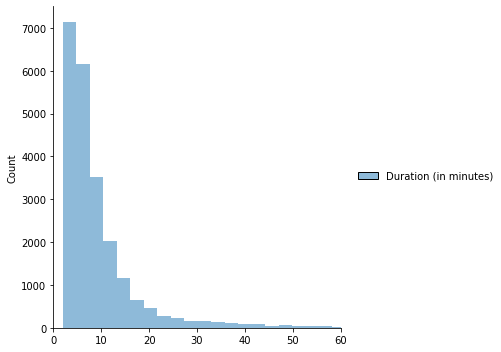

In [79]:
# Plot a histogram of user response times 
responses_only_duration = responses_df_2022['Duration (in seconds)']
responses_only_duration = pd.DataFrame(pd.to_numeric(responses_only_duration, errors='coerce')/60)
responses_only_duration.columns = ['Duration (in minutes)']
sns.displot(responses_only_duration,bins=15000).set(xlim=(0, 60))
median = round(responses_only_duration['Duration (in minutes)'].median(),0)
print('The median response time was approximately',median,'minutes.')
responses_only_duration_longer_5m = responses_only_duration[responses_only_duration['Duration (in minutes)'] > 5]  
print('The total number of respondents that took more than 5 minutes was',responses_only_duration_longer_5m.shape[0],'out of',responses_df_2022.shape[0])


**Future directions to consider:**
* Divide the population into interesting subgroups and identify interesting insights.

 * Do students have different preferences as compared to professionals?
 * Do GCP customers have different preferences as compared to AWS customers?
 * Which cloud computing platforms have seen the most growth in recent years?
 * Do salaries scale according to experience levels?  What traits might predict having a very high salary?



**Credits / Attribution:**

* The idea to use pattern matching to identify which columns are associated with which questions came from @siddhantsadangi's notebook ["Your Country VS The World"](https://www.kaggle.com/siddhantsadangi/your-country-vs-the-world-24-factors-wip) (see function grab_subset_of_data() for more detail).
* Most plotting functions were adapted from examples in the [plotly documentation](https://plotly.com/python/plotly-express/).
* This notebook (and every other public notebook on Kaggle) was released under an [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0). Consider clicking on the "copy & edit" button in the top right corner and then you can focus on some subset of the community that you find to be interesting!

In [80]:
!mkdir /kaggle/working/docker/
!pip freeze > '/kaggle/working/docker/requirements.txt'
print('This notebook makes use of \nthe following Python libraries:\n')
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('seaborn:',sns.__version__)
import plotly_express as px
print('plotly express:',px.__version__)

This notebook makes use of 
the following Python libraries:

numpy: 1.21.6
pandas: 1.3.5
seaborn: 0.11.2
plotly express: 0.4.1
